# Elliptic AML Dataset Exploration
Initial exploration and visualization of the dataset.

In [20]:
# Imports & setup
import os
import json
import math
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from pathlib import Path
from datetime import datetime

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import (
    roc_auc_score, average_precision_score,
    precision_recall_curve, roc_curve,
    classification_report, confusion_matrix
)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

DATA_PROCESSED = Path("../data/processed")
REPORT_FIG = Path("../reports/figures")
MODELS_DIR = Path("models")
for p in [REPORT_FIG, MODELS_DIR]:
    p.mkdir(parents=True, exist_ok=True)

print("Paths:")
print("Processed:", DATA_PROCESSED.resolve())
print("Figures:  ", REPORT_FIG.resolve())
print("Models:   ", MODELS_DIR.resolve())


Paths:
Processed: /Users/o/Desktop/projects/elliptic-aml-analysis/data/processed
Figures:   /Users/o/Desktop/projects/elliptic-aml-analysis/reports/figures
Models:    /Users/o/Desktop/projects/elliptic-aml-analysis/notebooks/models


In [21]:
# Load processed matrices (parquet first, fallback to csv)
def load_df(name: str) -> pd.DataFrame:
    p_parquet = DATA_PROCESSED / f"{name}.parquet"
    p_csv     = DATA_PROCESSED / f"{name}.csv"
    if p_parquet.exists():
        return pd.read_parquet(p_parquet)
    elif p_csv.exists():
        return pd.read_csv(p_csv)
    else:
        raise FileNotFoundError(f"Neither parquet nor csv found for {name}")

X_train = load_df("X_train")
X_valid = load_df("X_valid")
X_test  = load_df("X_test")

y_train = load_df("y_train")["label"].values
y_valid = load_df("y_valid")["label"].values
y_test  = load_df("y_test")["label"].values

feature_cols = list(X_train.columns)
print(f"Train shape: {X_train.shape}, Valid: {X_valid.shape}, Test: {X_test.shape}")
print(f"#Features: {len(feature_cols)}")

# Class balance summary
def class_summary(y, name):
    uniq, cnt = np.unique(y, return_counts=True)
    d = dict(zip(uniq, cnt))
    pos = d.get(1, 0); neg = d.get(0, 0)
    ratio = (pos / max(1, (pos+neg))) * 100
    print(f"{name}: Pos={pos}, Neg={neg}, Pos%={ratio:.2f}%")
    return pos, neg

pos_tr, neg_tr = class_summary(y_train, "Train")
pos_va, neg_va = class_summary(y_valid, "Valid")
pos_te, neg_te = class_summary(y_test,  "Test")


Train shape: (32595, 121), Valid: (4656, 121), Test: (9313, 121)
#Features: 121
Train: Pos=2659, Neg=29936, Pos%=8.16%
Valid: Pos=560, Neg=4096, Pos%=12.03%
Test: Pos=1326, Neg=7987, Pos%=14.24%


In [22]:
# Unified evaluation helpers

def evaluate_proba(y_true, y_proba, threshold=0.5):
    """Return a dict of key metrics and the confusion matrix at the threshold."""
    y_pred = (y_proba >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred, labels=[0,1])
    metrics = {
        "roc_auc": float(roc_auc_score(y_true, y_proba)),
        "pr_auc": float(average_precision_score(y_true, y_proba)),
        "threshold": float(threshold),
        "precision_recall_f1": classification_report(y_true, y_pred, output_dict=True),
        "confusion_matrix": cm.tolist()
    }
    return metrics

def plot_pr_curve(y_true, y_proba, title, save_path=None):
    precision, recall, thr = precision_recall_curve(y_true, y_proba)
    ap = average_precision_score(y_true, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(recall, precision, lw=2)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"{title}\nPR-AUC={ap:.3f}")
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
    plt.show()

def plot_roc_curve(y_true, y_proba, title, save_path=None):
    fpr, tpr, thr = roc_curve(y_true, y_proba)
    auc = roc_auc_score(y_true, y_proba)
    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr, lw=2, label=f"AUC={auc:.3f}")
    plt.plot([0,1],[0,1],'--',alpha=0.5)
    plt.xlabel("FPR")
    plt.ylabel("TPR")
    plt.title(title)
    plt.legend()
    plt.grid(True, alpha=0.3)
    if save_path:
        plt.tight_layout()
        plt.savefig(save_path, dpi=150)
    plt.show()

def pick_best_threshold_by_f1(y_true, y_proba, beta=1.0):
    """Scan thresholds on validation set to maximize F-beta (default F1)."""
    precision, recall, thresholds = precision_recall_curve(y_true, y_proba)
    # thresholds has len n-1; precision/recall has len n
    precision = precision[:-1]
    recall = recall[:-1]
    thresholds = thresholds
    beta2 = beta**2
    denom = (beta2 * precision + recall)
    fbeta = np.where(denom>0, (1+beta2) * (precision*recall) / denom, 0.0)
    idx = int(np.argmax(fbeta))
    return float(thresholds[idx]), float(fbeta[idx]), float(precision[idx]), float(recall[idx])


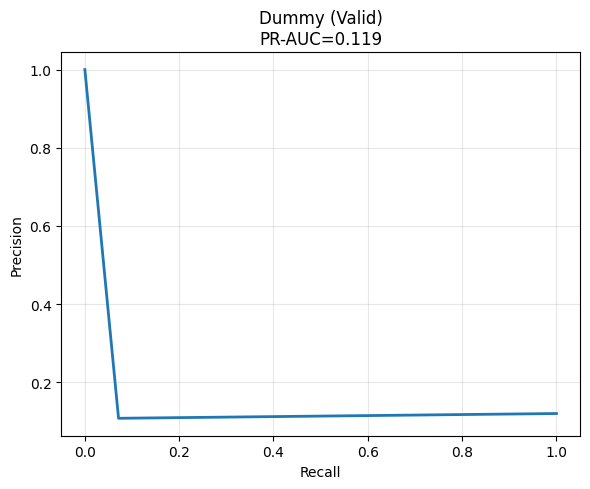

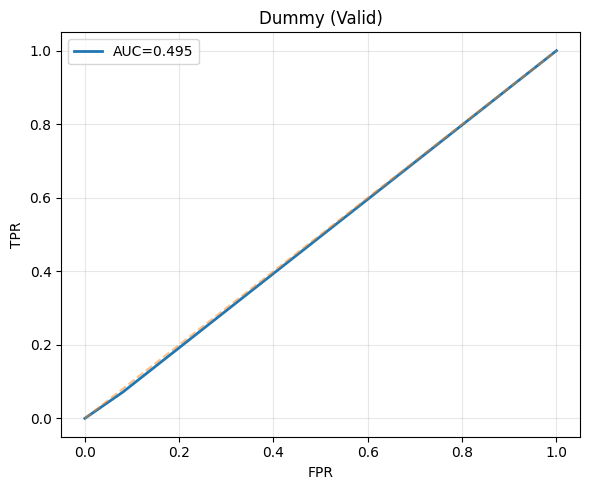

LogReg tuned threshold on Valid: {'best_threshold': 0.7687007812721903, 'best_f1': 0.7480798771121352, 'precision': 0.6563342318059299, 'recall': 0.8696428571428572}


/Users/o/Desktop/projects/elliptic-aml-analysis/.venv/lib/python3.13/site-packages/sklearn/linear_model/_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 200 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=200).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


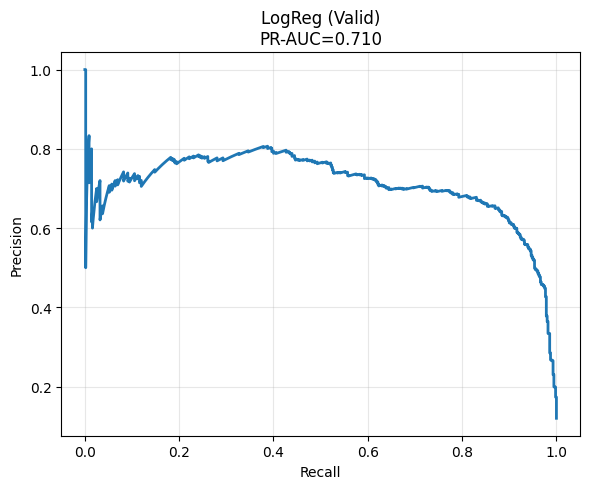

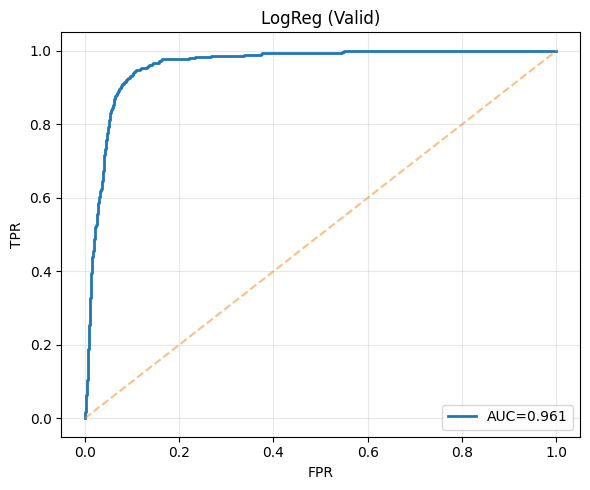

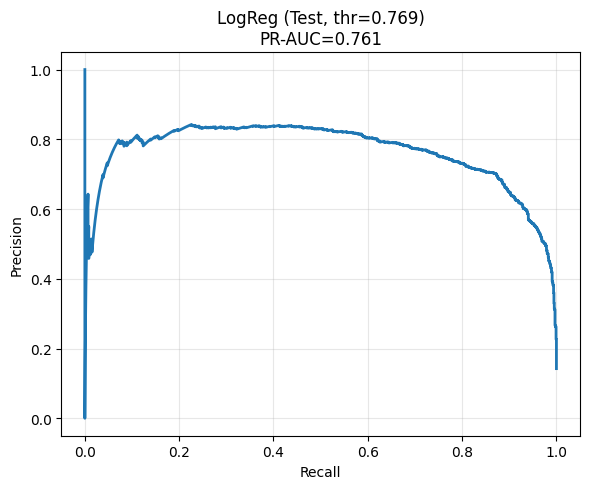

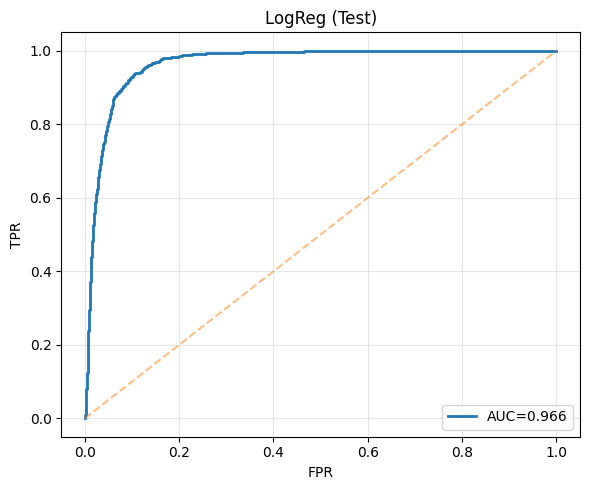

In [23]:
# Baselines
results = {}

# Dummy (stratified) – sanity check
dummy = DummyClassifier(strategy="stratified", random_state=RANDOM_SEED)
dummy.fit(X_train, y_train)
proba_va = dummy.predict_proba(X_valid)[:,1]
results["dummy_valid"] = evaluate_proba(y_valid, proba_va)
plot_pr_curve(y_valid, proba_va, "Dummy (Valid)", REPORT_FIG/"03_dummy_pr_valid.png")
plot_roc_curve(y_valid, proba_va, "Dummy (Valid)", REPORT_FIG/"03_dummy_roc_valid.png")

# Logistic Regression (already scaled features, use class_weight)
logreg = LogisticRegression(
    random_state=RANDOM_SEED,
    max_iter=200,
    class_weight="balanced",
    n_jobs=None # for sklearn < 1.6 parity on Mac
)
logreg.fit(X_train, y_train)
proba_va_lr = logreg.predict_proba(X_valid)[:,1]
results["logreg_valid_default"] = evaluate_proba(y_valid, proba_va_lr, threshold=0.5)

# Tune threshold on validation
thr_best, f1_best, p_at_best, r_at_best = pick_best_threshold_by_f1(y_valid, proba_va_lr, beta=1.0)
results["logreg_valid_tuned_threshold"] = {
    "best_threshold": thr_best, "best_f1": f1_best, "precision": p_at_best, "recall": r_at_best
}

print("LogReg tuned threshold on Valid:", results["logreg_valid_tuned_threshold"])

# Test with tuned threshold
proba_te_lr = logreg.predict_proba(X_test)[:,1]
results["logreg_test_default"] = evaluate_proba(y_test, proba_te_lr, threshold=0.5)
results["logreg_test_tuned"]   = evaluate_proba(y_test, proba_te_lr, threshold=thr_best)

# Curves
plot_pr_curve(y_valid, proba_va_lr, "LogReg (Valid)", REPORT_FIG/"03_logreg_pr_valid.png")
plot_roc_curve(y_valid, proba_va_lr, "LogReg (Valid)", REPORT_FIG/"03_logreg_roc_valid.png")

plot_pr_curve(y_test, proba_te_lr, f"LogReg (Test, thr={thr_best:.3f})", REPORT_FIG/"03_logreg_pr_test.png")
plot_roc_curve(y_test, proba_te_lr, "LogReg (Test)", REPORT_FIG/"03_logreg_roc_test.png")


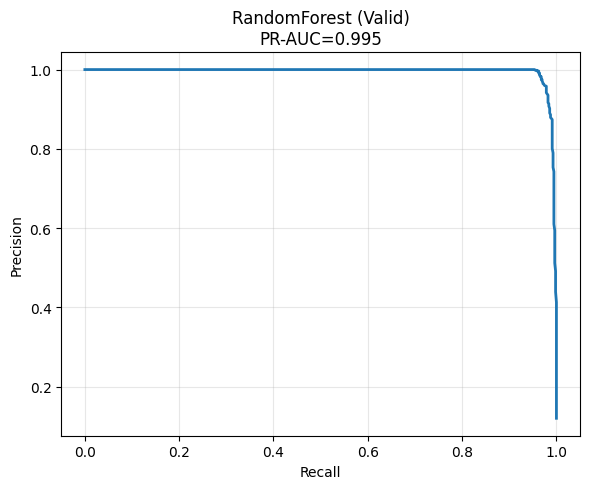

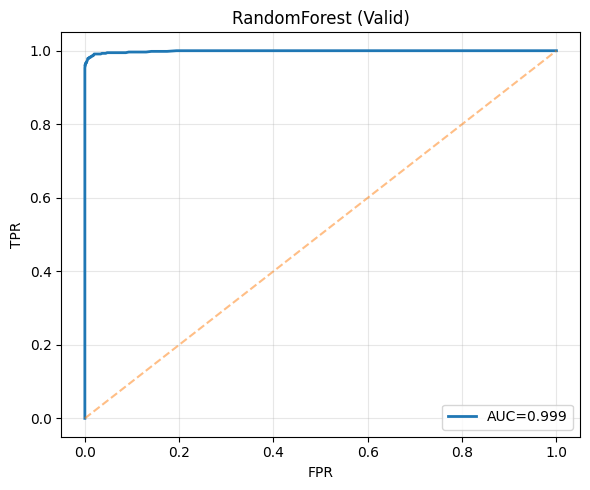

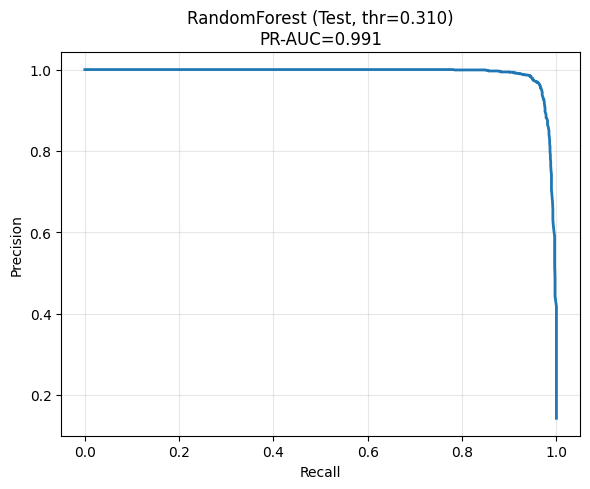

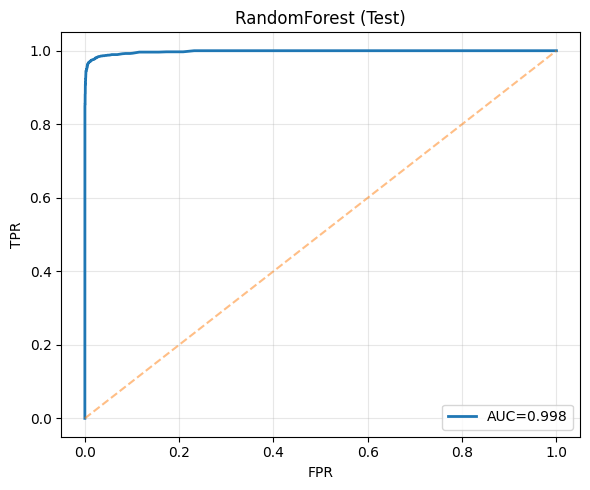

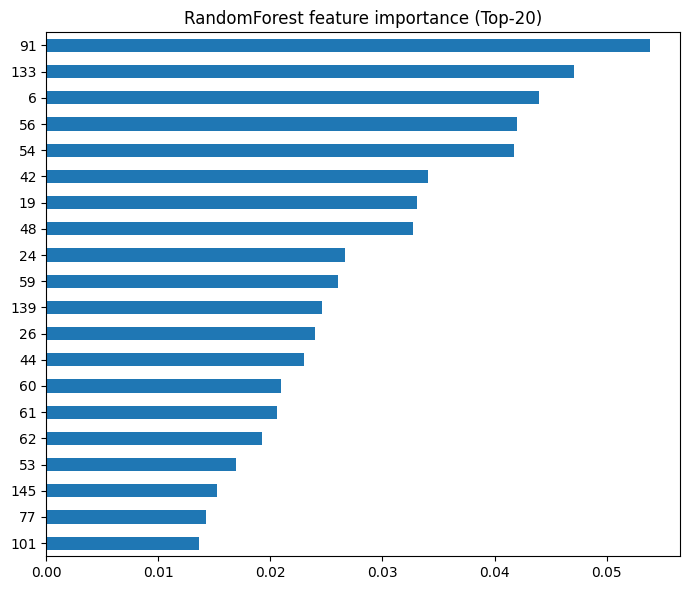

In [24]:
# RandomForest with class_weight
rf = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    min_samples_split=2,
    n_jobs=-1,
    random_state=RANDOM_SEED,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

proba_va_rf = rf.predict_proba(X_valid)[:,1]
thr_rf, f1_rf, p_rf, r_rf = pick_best_threshold_by_f1(y_valid, proba_va_rf, beta=1.0)

proba_te_rf = rf.predict_proba(X_test)[:,1]
rf_valid_metrics_default = evaluate_proba(y_valid, proba_va_rf, threshold=0.5)
rf_test_metrics_default  = evaluate_proba(y_test,  proba_te_rf, threshold=0.5)
rf_test_metrics_tuned    = evaluate_proba(y_test,  proba_te_rf, threshold=thr_rf)

results["rf_valid_default"] = rf_valid_metrics_default
results["rf_valid_tuned_threshold"] = {"best_threshold": thr_rf, "best_f1": f1_rf, "precision": p_rf, "recall": r_rf}
results["rf_test_default"] = rf_test_metrics_default
results["rf_test_tuned"]   = rf_test_metrics_tuned

# Curves
plot_pr_curve(y_valid, proba_va_rf, "RandomForest (Valid)", REPORT_FIG/"03_rf_pr_valid.png")
plot_roc_curve(y_valid, proba_va_rf, "RandomForest (Valid)", REPORT_FIG/"03_rf_roc_valid.png")
plot_pr_curve(y_test,  proba_te_rf, f"RandomForest (Test, thr={thr_rf:.3f})", REPORT_FIG/"03_rf_pr_test.png")
plot_roc_curve(y_test,  proba_te_rf, "RandomForest (Test)", REPORT_FIG/"03_rf_roc_test.png")

# Feature importance (top-20)
imp = pd.Series(rf.feature_importances_, index=feature_cols).sort_values(ascending=False).head(20)
plt.figure(figsize=(7,6))
imp[::-1].plot(kind="barh")
plt.title("RandomForest feature importance (Top-20)")
plt.tight_layout()
plt.savefig(REPORT_FIG/"03_rf_feature_importance_top20.png", dpi=150)
plt.show()


In [25]:
# XGBoost (optional)
try:
    import xgboost as xgb

    # scale_pos_weight ~ (neg/pos) in TRAIN
    neg, pos = np.bincount(y_train)
    spw = (neg / max(1,pos))

    xgb_clf = xgb.XGBClassifier(
        n_estimators=400,
        max_depth=6,
        learning_rate=0.08,
        subsample=0.9,
        colsample_bytree=0.9,
        reg_lambda=1.0,
        random_state=RANDOM_SEED,
        tree_method="hist",
        n_jobs=-1,
        scale_pos_weight=spw
    )
    xgb_clf.fit(X_train, y_train)

    proba_va_xgb = xgb_clf.predict_proba(X_valid)[:,1]
    thr_xgb, f1_xgb, p_xgb, r_xgb = pick_best_threshold_by_f1(y_valid, proba_va_xgb, beta=1.0)

    proba_te_xgb = xgb_clf.predict_proba(X_test)[:,1]
    results["xgb_valid_default"] = evaluate_proba(y_valid, proba_va_xgb, threshold=0.5)
    results["xgb_valid_tuned_threshold"] = {"best_threshold": thr_xgb, "best_f1": f1_xgb, "precision": p_xgb, "recall": r_xgb}
    results["xgb_test_default"] = evaluate_proba(y_test, proba_te_xgb, threshold=0.5)
    results["xgb_test_tuned"]   = evaluate_proba(y_test, proba_te_xgb, threshold=thr_xgb)

    plot_pr_curve(y_valid, proba_va_xgb, "XGBoost (Valid)", REPORT_FIG/"03_xgb_pr_valid.png")
    plot_roc_curve(y_valid, proba_va_xgb, "XGBoost (Valid)", REPORT_FIG/"03_xgb_roc_valid.png")
    plot_pr_curve(y_test,  proba_te_xgb, f"XGBoost (Test, thr={thr_xgb:.3f})", REPORT_FIG/"03_xgb_pr_test.png")
    plot_roc_curve(y_test,  proba_te_xgb, "XGBoost (Test)", REPORT_FIG/"03_xgb_roc_test.png")

    # Feature importance (gain)
    booster = xgb_clf.get_booster()
    score = booster.get_score(importance_type="gain")
    # Map f0.. to feature names
    fmap = {f"f{i}": c for i, c in enumerate(feature_cols)}
    imp_gain = pd.Series({fmap.get(k,k): v for k,v in score.items()}).sort_values(ascending=False).head(20)
    plt.figure(figsize=(7,6))
    imp_gain[::-1].plot(kind="barh")
    plt.title("XGBoost feature importance (Top-20, gain)")
    plt.tight_layout()
    plt.savefig(REPORT_FIG/"03_xgb_feature_importance_top20.png", dpi=150)
    plt.show()

except Exception as e:
    print("XGBoost not available or failed to run:", repr(e))


XGBoost not available or failed to run: XGBoostError('\nXGBoost Library (libxgboost.dylib) could not be loaded.\nLikely causes:\n  * OpenMP runtime is not installed\n    - vcomp140.dll or libgomp-1.dll for Windows\n    - libomp.dylib for Mac OSX\n    - libgomp.so for Linux and other UNIX-like OSes\n    Mac OSX users: Run `brew install libomp` to install OpenMP runtime.\n\n  * You are running 32-bit Python on a 64-bit OS\n\nError message(s): ["dlopen(/Users/o/Desktop/projects/elliptic-aml-analysis/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib, 0x0006): Library not loaded: @rpath/libomp.dylib\\n  Referenced from: <6984A3F0-3899-36C4-A85D-20B5520FF130> /Users/o/Desktop/projects/elliptic-aml-analysis/.venv/lib/python3.13/site-packages/xgboost/lib/libxgboost.dylib\\n  Reason: tried: \'/opt/homebrew/opt/libomp/lib/libomp.dylib\' (no such file), \'/System/Volumes/Preboot/Cryptexes/OS/opt/homebrew/opt/libomp/lib/libomp.dylib\' (no such file), \'/opt/homebrew/opt/libomp/lib/li

In [18]:
# === Robust summary & artifact saving ===

from datetime import datetime

def extract_main_scores_safe(tag, res_dict, key="precision_recall_f1"):
    """Safely extract a compact row for comparison; return None if structure is unexpected."""
    try:
        prf = res_dict.get(key, {})
        # minority (= positive class 1) metrics
        f1 = prf.get("1", {}).get("f1-score", np.nan)
        p  = prf.get("1", {}).get("precision", np.nan)
        r  = prf.get("1", {}).get("recall", np.nan)
        row = {
            "tag": tag,
            "roc_auc": res_dict.get("roc_auc", np.nan),
            "pr_auc": res_dict.get("pr_auc", np.nan),
            "minority_precision": p,
            "minority_recall": r,
            "minority_f1": f1,
            "threshold": res_dict.get("threshold", np.nan),
        }
        return row
    except Exception as e:
        print(f"[WARN] Could not extract scores for {tag}: {repr(e)}")
        return None

# Which result tags we *expect* to exist
expected_tags = [
    "logreg_test_default",
    "logreg_test_tuned",
    "rf_test_default",
    "rf_test_tuned",
    "xgb_test_default",
    "xgb_test_tuned",
]

# Show what we actually have
print("Available result keys:", sorted(results.keys()))

summary_rows = []
present_tags = [t for t in expected_tags if t in results]
missing_tags  = [t for t in expected_tags if t not in results]

if missing_tags:
    print("[INFO] Missing result tags (likely model skipped or earlier cell not run):", missing_tags)

for tag in present_tags:
    row = extract_main_scores_safe(tag, results[tag])
    if row is not None:
        summary_rows.append(row)

# Build DataFrame with guaranteed columns (even if empty)
columns = ["tag","roc_auc","pr_auc","minority_precision","minority_recall","minority_f1","threshold"]
summary_df = pd.DataFrame(summary_rows, columns=columns)

if len(summary_df) == 0:
    print("[ERROR] No summary rows assembled. Double-check earlier cells executed without errors.")
else:
    # Sort only if columns exist (they do) – NaNs will sink to bottom by default
    summary_df = summary_df.sort_values(by=["pr_auc", "minority_f1"], ascending=False)
    display(summary_df)

    # Save artifacts
    ts = datetime.now().strftime("%Y%m%d_%H%M%S")
    out_csv = DATA_PROCESSED / f"03_model_summary_{ts}.csv"
    out_json = DATA_PROCESSED / f"03_model_results_{ts}.json"
    summary_df.to_csv(out_csv, index=False)
    with open(out_json, "w") as f:
        json.dump(results, f, indent=2)

    # Save models safely
    joblib.dump(logreg, MODELS_DIR / f"logreg_{ts}.joblib")
    joblib.dump(rf,     MODELS_DIR / f"rf_{ts}.joblib")
    try:
        # Only if xgb_clf exists
        joblib.dump(xgb_clf, MODELS_DIR / f"xgb_{ts}.joblib")
    except NameError:
        pass

    print("Saved:")
    print(" - summary CSV:", out_csv)
    print(" - raw results JSON:", out_json)
    print(" - models in:", MODELS_DIR)
    print(" - figures in:", REPORT_FIG)


Available result keys: ['dummy_valid', 'logreg_test_default', 'logreg_test_tuned', 'logreg_valid_default', 'logreg_valid_tuned_threshold', 'rf_test_default', 'rf_test_tuned', 'rf_valid_default', 'rf_valid_tuned_threshold']
[INFO] Missing result tags (likely model skipped or earlier cell not run): ['xgb_test_default', 'xgb_test_tuned']


,tag,roc_auc,pr_auc,minority_precision,minority_recall,minority_f1,threshold
3,rf_test_tuned,0.997837,0.991203,0.969512,0.959276,0.964367,0.310000
2,rf_test_default,0.997837,0.991203,0.990252,0.919306,0.953461,0.500000
1,logreg_test_tuned,0.965863,0.760905,0.690660,0.875566,0.772198,0.768701
0,logreg_test_default,0.965863,0.760905,0.515249,0.968326,0.672603,0.500000


Saved:
 - summary CSV: ../data/processed/03_model_summary_20250908_144859.csv
 - raw results JSON: ../data/processed/03_model_results_20250908_144859.json
 - models in: models
 - figures in: ../reports/figures
